### This section deals with the missing values in the raw dataset('missing_data.csv')

# Dataset

country : user country based on the IP address

age : user age. Self-reported at sign-up step

new_user : whether the user created the account during this session or had already an account and simply came back to the site

source : marketing channel source

Ads: came to the site by clicking on an advertisement
Seo: came to the site by clicking on search results
Direct: came to the site by directly typing the URL on the browser
total_pages_visited: number of total pages visited during the session. This can be seen as a proxy for time spent on site and engagement

converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything.

In [11]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [12]:
data = pandas.read_csv('missing_data.csv')

In [8]:
print(data.describe(include='all'))

       country            age      is_mobile  source      converted
count    95502  120704.000000  120704.000000  120704  120704.000000
unique       3            NaN            NaN       3            NaN
top         UK            NaN            NaN     Seo            NaN
freq     69626            NaN            NaN   59324            NaN
mean       NaN      44.575258       0.631006     NaN       0.169845
std        NaN      11.661944       0.482534     NaN       0.375498
min        NaN      17.000000       0.000000     NaN       0.000000
25%        NaN      36.000000       0.000000     NaN       0.000000
50%        NaN      44.000000       1.000000     NaN       0.000000
75%        NaN      53.000000       1.000000     NaN       0.000000
max        NaN      80.000000       1.000000     NaN       1.000000


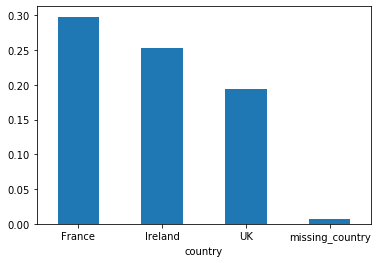

In [9]:
#check conversion rate of missing values vs non-missing values
#Group by country and check conversion rate
data.fillna("missing_country").groupby(['country'])['converted'].mean().plot.bar()
plt.xticks(rotation=0)
tplt.show()

The conversion rate tend to be much worse when the country is missing. This is an example of self-selection bias. The least engaged customers are usually those who choose not to fill out certain information thenselves. 


### Replace missing values with values sampled with replacement from that variable.


In [13]:
#set seed to reproduce the results
np.random.seed(46)
  
data_replace = data.copy()
  
#split into train and test 
train, test = train_test_split(data_replace, test_size = 0.34)
train = train.reset_index(drop=True).copy()
test =  test.reset_index(drop=True).copy()
  
#replace NAs with randomly selected countries according to the origianl country distribution
train['country'] = train['country'].fillna(pandas.Series(np.random.choice( train['country'].dropna() , size=len(train['country']) )))
test['country'] = test['country'].fillna(pandas.Series(np.random.choice( test['country'].dropna() , size=len(test['country']) )))
  
#create dummies
train = pandas.get_dummies(train, drop_first=True)
test =  pandas.get_dummies(test, drop_first=True)
  
#build the model. We will use a RF, but it is the same with any other model. We balance the weights to reduce class 1 errors
rf_replace_sampling = RandomForestClassifier(n_estimators=50, oob_score=True, class_weight={0:1,1:5})
rf_replace_sampling.fit(train.drop('converted', axis=1), train['converted'])
  
#print test set confusion matrix
conf_matrix_sampling = pandas.DataFrame(confusion_matrix(test['converted'], rf_replace_sampling.predict(test.drop('converted', axis=1)), labels=[0, 1]))
print(conf_matrix_sampling)

       0      1
0  23770  10370
1   2078   4822


In [14]:
#print model accuracy and class errors
class0_error = 1 - conf_matrix_sampling.loc[0,0]/(conf_matrix_sampling.loc[0,0]+conf_matrix_sampling.loc[0,1])
class1_error = 1 - conf_matrix_sampling.loc[1,1]/(conf_matrix_sampling.loc[1,0]+conf_matrix_sampling.loc[1,1])
  
print(pandas.DataFrame( {'accuracy': rf_replace_sampling.score(test.drop('converted', axis=1),test['converted']),
                         'class0_error' :[class0_error],
                         'class1_error' :[class1_error]
}))

   accuracy  class0_error  class1_error
0  0.696686      0.303749      0.301159


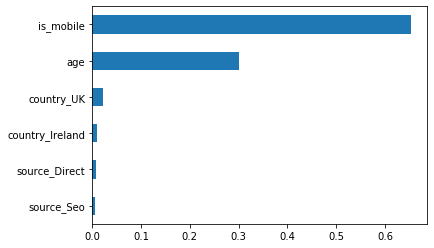

In [15]:
#variable importance
pandas.Series(rf_replace_sampling.feature_importances_, index=train.drop('converted', axis=1).columns).sort_values(ascending=True).plot(kind='barh')
plt.show()

### create a dummy variable to indicate missing value

In [16]:
#replace missing values with "missing_country". Need to convert it to character and then back to factor
data['country'] = data['country'].fillna("missing_country")
  
#create dummy vars
data = pandas.get_dummies(data, drop_first=True)
  
#split test/train
train_leave_NA, test_leave_NA = train_test_split(data, test_size = 0.34)
  
#build the model. We will use a RF, but it is the same with any other model. We slightly adjust the weights to reduce class 1 errors
rf_model_leave_NA = RandomForestClassifier(n_estimators=50, oob_score=True, class_weight={0:1,1:5})
rf_model_leave_NA.fit(train_leave_NA.drop('converted', axis=1), train_leave_NA['converted'])
#and let's print test set confusion matrix
conf_matrix_leave_NA = pandas.DataFrame(confusion_matrix(test_leave_NA['converted'], rf_model_leave_NA.predict(test_leave_NA.drop('converted', axis=1)), labels=[0, 1]))
print(conf_matrix_leave_NA)

       0     1
0  25158  8822
1   1898  5162


In [17]:
#print model accuracy and class errors
class0_error_leave_NA = 1 - conf_matrix_leave_NA.loc[0,0]/(conf_matrix_leave_NA.loc[0,0]+conf_matrix_leave_NA.loc[0,1])
class1_error_leave_NA = 1 - conf_matrix_leave_NA.loc[1,1]/(conf_matrix_leave_NA.loc[1,0]+conf_matrix_leave_NA.loc[1,1])
print(pandas.DataFrame( {'accuracy_leave_NA': rf_model_leave_NA.score(test_leave_NA.drop('converted', axis=1),test_leave_NA['converted']),
                         'class0_error_leave_NA' :[class0_error_leave_NA],
                         'class1_error_leave_NA' :[class1_error_leave_NA]
}))

   accuracy_leave_NA  class0_error_leave_NA  class1_error_leave_NA
0           0.738791               0.259623               0.268839


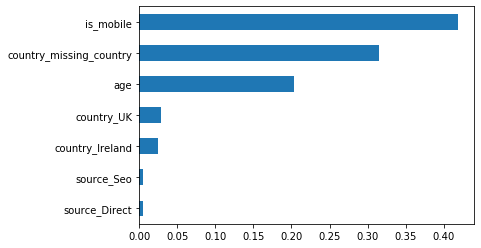

In [18]:
#variable importance
pandas.Series(rf_model_leave_NA.feature_importances_, index=train_leave_NA.drop('converted', axis=1).columns).sort_values(ascending=True).plot(kind='barh')
plt.show()

Base on the two variable importance plots, the dummy variable “missing_country” is extremely important by itself. By removing it, we would be losing crucial information used by the model


Interestingly, the importance of the other country levels (UK and Ireland) goes down when we replace the missing values by sampling. This is because we “polluted” their information by adding new events with totally different distribution, i.e. much lower conversion rate. So we made those segments noisier and the model is having a harder time extracting information out of them


The model with “missing_country” does significantly better than the one where we replaced NAs by sampling. Accuracy, class 0 error, and class 1 error are all significantly better when using “missing_country”.

